### Elastic constants

$E =  E_0 + \frac{1}{2} V \sum \epsilon_i^T C_{ij}\epsilon_j$.

The strain matrices are

$
\begin{align}
\epsilon_{11} = 
\left(
\begin{array}{ccc}
\epsilon & 0 &0 \\
0 & 0 &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{22} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\"
0 & \epsilon &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{33} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & 0 &0 \\
0 & 0 &\epsilon \\
\end{array}
\right)\\
\epsilon_{12} = 
\left(
\begin{array}{ccc}
0 & \epsilon &0 \\
0 & 0 &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{13} = 
\left(
\begin{array}{ccc}
0 & 0 &\epsilon \\
0 & 0 &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{23} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & 0 &\epsilon \\
0 & 0 &0 \\
\end{array}
\right)\\
\epsilon_{21} = 
\left(
\begin{array}{ccc}
0& 0 &0 \\
\epsilon & 0 &0 \\
0 & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{31} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & 0 &0 \\
\epsilon & 0 &0 \\
\end{array}
\right)
\quad\quad
\epsilon_{32} = 
\left(
\begin{array}{ccc}
0 & 0 &0 \\
0 & 0 &0 \\
0 &\epsilon &0\\
\end{array}
\right)\\
\end{align}
$

and the corresponding strain Voigt 'vectors' are

$
\begin{align}
\epsilon_1 &= (\epsilon_{11}, 0, 0, 0, 0 ,0)\\
\epsilon_2 &= (0, \epsilon_{22}, 0, 0, 0 ,0)\\
\epsilon_3 &= (0, 0, \epsilon_{33}, 0, 0 ,0)\\
\epsilon_4 &= (0, 0, 0, 2\epsilon_{23}, 0 ,0)\\
\epsilon_5 &= (0, 0, 0, 0, 2\epsilon_{13} ,0)\\
\epsilon_6 &= (0, 0, 0, 0, 0 ,2\epsilon_{12})
\end{align}
$

In general, we first compute the diagonals $C_{ii}$ by solving

$E = E_0 + \frac{1}{2} V_0 C_{ii} \epsilon_{i}\epsilon_{i}$

and then the off-diagonals,

$E = E_0 + \frac{1}{2} V_0 C_{ii} \epsilon_{i}\epsilon_{i}
+ \frac{1}{2} V_0 C_{jj} \epsilon_{j}\epsilon_{j}
+ V_0 C_{ij} \epsilon_{i}\epsilon_{j}
$


In [31]:
from pyiron import Project
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize
import ase.units

In [32]:
potential =  'FeH-NNIP'

In [7]:
pr = Project("Elastic_C")

In [10]:
# structure optimization
job = pr.create.job.Lammps("optimise", delete_existing_job=True)
job.structure = pr.create.structure.bulk('Fe', crystalstructure='bcc', cubic=True)
job.potential = potential
job.calc_minimize(pressure=0.0)
job.run(delete_existing_job=True)

# get E0, V0
structure_opt = job.get_structure(frame=-1)
cell = structure_opt.get_cell()
e0   = job.output.energy_pot[-1]
v0   = structure_opt.get_volume()

The job optimise was saved and received the ID: 10090


In [11]:
strains = [-0.01, -0.005, 0.005, 0.01]
shear_strains = [0.005, 0.01, 0.015, 0.02]

I = np.diag((1, 1, 1))

def strain(e, i, j):
    voigt_map = {1:[1, 1], 2:[2, 2], 3:[3, 3],
                 4:[2, 3], 5:[1, 3], 6:[1, 2]}

    k, l = voigt_map[i]
    eps1 = np.zeros((3, 3))
    eps1[k-1][l-1] += e/2
    eps1[l-1][k-1] += e/2
    k, l = voigt_map[j]
    eps2 = np.zeros((3, 3))
    eps2[k-1][l-1] += e/2
    eps2[l-1][k-1] += e/2
    return (eps1 + eps2)/2

The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091


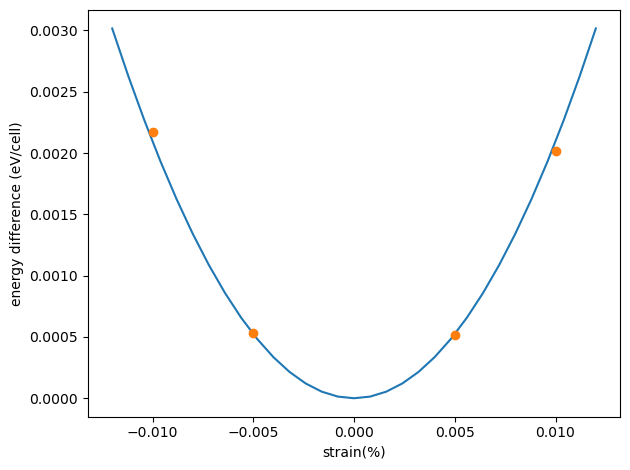

C11 = 296.12 GPa


In [12]:
# C11 calculation
data = []
for e in strains:
    D = I + strain(e, 1, 1)
    structure = structure_opt.copy()
    cell = structure_opt.get_cell()
    structure.set_cell(D.dot(cell.T).T, scale_atoms=True)
    job = pr.create.job.Lammps("minimise", delete_existing_job=True)
    job.structure = structure
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    en = job.output.energy_tot[-1]
    v = structure.get_volume()
    data.append([e, v, en-e0])

E = lambda eps, C: 0.5*v0 * C * eps**2

eps, volumes, energies = zip(*data)

popt = scipy.optimize.curve_fit(E, eps, energies)
C11  = popt[0]

x = np.linspace(-eps[-1]*1.2, eps[-1]*1.2, 31)
plt.figure()
plt.plot(x, E(x, C11))
plt.plot(eps, energies, "o")
plt.xlabel("strain(%)")
plt.ylabel("energy difference (eV/cell)")
plt.tight_layout()
plt.show()

print("C11 = %.2f GPa" %(C11[0] / ase.units.kJ * 1.0e24))

The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091


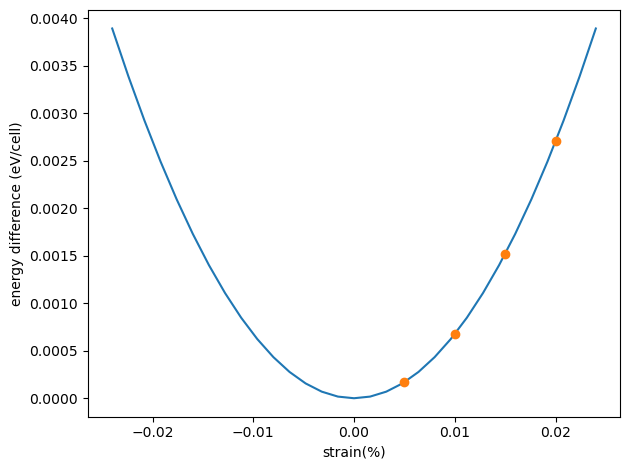

C44 = 95.56 GPa


In [14]:
# C44 calculation
data = []
for e in shear_strains:
    D = I + strain(e, 4, 4)
    structure = structure_opt.copy()
    cell = structure_opt.cell
    structure.set_cell(D.dot(cell.T).T, scale_atoms=True)
    job = pr.create.job.Lammps("minimise", delete_existing_job=True)
    job.structure = structure
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    en = job.output.energy_tot[-1]
    v = structure.get_volume()
    data.append([e, v, en-e0])

E = lambda eps, C: 0.5*v0 * C * eps**2

eps, volumes, energies = zip(*data)

popt = scipy.optimize.curve_fit(E, eps, energies)
C44  = popt[0]

x = np.linspace(-eps[-1]*1.2, eps[-1]*1.2, 31)
plt.figure()
plt.plot(x, E(x, C44))
plt.plot(eps, energies, "o")
plt.xlabel("strain(%)")
plt.ylabel("energy difference (eV/cell)")
plt.tight_layout()
plt.show()

print("C44 = %.2f GPa" %(C44[0] / ase.units.kJ * 1.0e24))

The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091
The job minimise was saved and received the ID: 10091


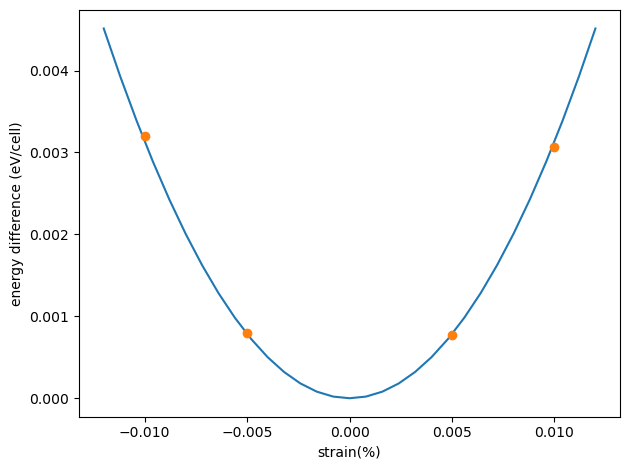

C12 = 146.99 GPa


In [15]:
# C12 calculation
data = []
for e in strains:
    D = I + strain(e, 1, 2)
    structure = structure_opt.copy()
    cell = structure_opt.cell
    structure.set_cell(D.dot(cell.T).T, scale_atoms=True)
    job = pr.create.job.Lammps("minimise", delete_existing_job=True)
    job.structure = structure
    job.potential = potential
    job.calc_minimize()
    job.run(delete_existing_job=True)
    en = job.output.energy_tot[-1]
    v = structure.get_volume()
    data.append([e, v, (en - e0)*2] )


E = lambda eps, C: 0.5 * v0 * C * eps**2

eps, volumes, energies = zip(*data)

popt = scipy.optimize.curve_fit(E, eps, energies)
C  = popt[0]

x = np.linspace(-eps[-1]*1.2, eps[-1]*1.2, 31)
plt.figure()
plt.plot(x, E(x, C))
plt.plot(eps, energies, "o")
plt.xlabel("strain(%)")
plt.ylabel("energy difference (eV/cell)")
plt.tight_layout()
plt.show()

print("C12 = %.2f GPa" %((C[0]-C11[0]) / ase.units.kJ * 1.0e24))


In [16]:
# build-in module: ElasticTensor
job_ref = pr.create.job.Lammps('reference', delete_existing_job=True)
job_ref.structure = structure_opt
job_ref.potential = potential

In [21]:
elastic = job_ref.create_job(job_type='ElasticTensor', job_name='ET', delete_existing_job=True)
elastic.input

,Parameter,Value,Comment
0,min_num_measurements,11,minimum number of samples to be taken
1,min_num_points,105,minimum number of data points(number of measur...
2,max_strain,0.01,relative volume variation around volume define...
3,polynomial_order,2,
4,additional_points,0,number of additional linear-dependent points t...
5,strain_matrices,[],List of strain matrices (generated automatical...
6,use_symmetry,True,Whether to consider box symmetries
7,rotations,[],List of rotation matrices (generated automatic...
8,normalize_magnitude,False,"Whether or normalize magnitude, so that the Fr..."
9,use_elements,True,Whether or not consider chemical elements for ...


In [22]:
elastic.run(delete_existing_job=True)

The job ET was saved and received the ID: 10092
The job ET_0 was saved and received the ID: 10093
The job ET_1 was saved and received the ID: 10094
The job ET_2 was saved and received the ID: 10095
The job ET_3 was saved and received the ID: 10096
The job ET_4 was saved and received the ID: 10097
The job ET_5 was saved and received the ID: 10098
The job ET_6 was saved and received the ID: 10099
The job ET_7 was saved and received the ID: 10100
The job ET_8 was saved and received the ID: 10101
The job ET_9 was saved and received the ID: 10102
The job ET_10 was saved and received the ID: 10103
The job ET_11 was saved and received the ID: 10104
The job ET_12 was saved and received the ID: 10105
The job ET_13 was saved and received the ID: 10106
The job ET_14 was saved and received the ID: 10107
The job ET_15 was saved and received the ID: 10108
The job ET_16 was saved and received the ID: 10109
The job ET_17 was saved and received the ID: 10110
The job ET_18 was saved and received the ID:

In [30]:
C = elastic['output/elastic_tensor']
C

array([[ 2.94135390e+02,  1.45869279e+02,  1.45863569e+02,
        -1.80132629e-02,  1.54121628e-02, -3.29874365e-03],
       [ 1.45863195e+02,  2.94130235e+02,  1.45862306e+02,
        -2.10528652e-02,  1.55628817e-02,  2.14968775e-04],
       [ 1.45868902e+02,  1.45870351e+02,  2.94141133e+02,
        -2.06558431e-02,  1.23338144e-02, -1.03856847e-02],
       [-6.28927036e-03, -4.18817596e-03, -4.40191280e-03,
         9.57242786e+01,  7.66540805e-03,  7.63342566e-03],
       [ 7.80911639e-03, -2.50402633e-03,  4.73602716e-03,
        -3.26807171e-03,  9.57206582e+01, -4.90735289e-03],
       [ 6.39282714e-03,  4.70910459e-03, -1.65484742e-03,
         8.31102671e-03, -4.94289539e-03,  9.57284566e+01]])

In [26]:
C11 = C[0][0]
C11

294.13539033541883

In [28]:
C44 = C[3][3]
C44

95.72427858362201

In [29]:
C12 = C[0][1]
C12

145.869278711709